In [24]:
# Install prerequesite libraries
#!pip install torch torchvision transformers datasets pandas seaborn

# 1. Dataset

In [25]:
# The chosen 13 + 1 labels
label_map = {
    18: "love",
    11: "disgust",
    17: "joy",
    25: "sadness",
    13: "excitement",
    14: "fear",
    2: "anger",
    15: "gratitude",
    12: "embarrassment",
    4: "approval",
    10: "disapproval",
    7: "curiosity",
    23: "relief",
    27: "neutral"
}

In [26]:
# Load dataset
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions", "simplified")

# Access the train, validation, and test splits
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
train_dataset[0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [27],
 'id': 'eebbqej'}

### 1.1. Preprocess the dataset

In [28]:
from transformers import AutoTokenizer

# Replace 'bert-base-uncased' with the pre-trained model of your choice
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Max sequence length in dataset = 30
def preprocess_dataset(example):
  # Tokenize the input text and return the encoded result
  encoding = tokenizer(example["text"], truncation=True, padding="max_length", max_length=30)
  return encoding

# Filter selected labels to remove labels that are not in the label_map
def filter_selected_labels(example):
  for i in example["labels"]:
    if int(i) in label_map.keys():
        return True
  return False

from torch.utils.data import DataLoader

# fill statistics data while mapping
label_frequency_statistics = {}
text_data = [example["text"] for example in dataset["train"]]
text_lengths = [len(text.split()) for text in text_data]

# Preprocess the dataset
train_dataset = train_dataset.map(preprocess_dataset, batched=True)
val_dataset = val_dataset.map(preprocess_dataset, batched=True)
test_dataset = test_dataset.map(preprocess_dataset, batched=True)

# Set dataset format to PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_dataset = train_dataset.filter(filter_selected_labels)
val_dataset = val_dataset.filter(filter_selected_labels)
test_dataset = test_dataset.filter(filter_selected_labels)

labels_debug = []
def map_selected_labels(example):
  label = [label for label in example["labels"] if int(label) in label_map.keys()][0]
  labels_debug.append(label)
  example["labels"] = [label]

  label = int(label)
  text = example["text"]
  if label not in label_frequency_statistics:
    label_frequency_statistics[label] = text
  else:
    label_frequency_statistics[label] += " " + text
  
  return example

train_dataset = train_dataset.map(map_selected_labels)
val_dataset = val_dataset.map(map_selected_labels)
test_dataset = test_dataset.map(map_selected_labels)

#print(labels_debug)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/3916 [00:00<?, ? examples/s]

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

In [29]:
# Verify we are only using existing classes
label_frequency_statistics.keys()

dict_keys([27, 4, 25, 15, 2, 10, 18, 12, 7, 17, 14, 13, 11, 23])

### Dataset analysis & charts

In [30]:
# Print first 100 labels in the dataset
print([int(label) for label in train_dataset["labels"][:100]])

[27, 27, 2, 14, 15, 27, 4, 27, 12, 15, 2, 27, 27, 12, 27, 27, 27, 2, 27, 25, 15, 27, 2, 27, 2, 17, 27, 25, 27, 15, 15, 27, 27, 7, 10, 27, 27, 27, 27, 27, 4, 27, 13, 10, 27, 27, 27, 15, 12, 27, 13, 27, 15, 27, 27, 27, 27, 27, 27, 13, 27, 13, 4, 25, 4, 27, 25, 15, 4, 27, 4, 27, 18, 4, 27, 7, 27, 7, 27, 10, 27, 27, 27, 7, 27, 15, 27, 27, 17, 27, 2, 2, 27, 27, 27, 4, 27, 2, 7, 2]


### 1.2 Prepare statistics data to be visualised

In [31]:
label_statistics = {label: 0 for label in label_map.values()}

# Gather statistics for piechart, barchart...
for example in train_dataset:
  for label_idx in example["labels"]:
    label = label_map[int(label_idx)]
    label_statistics[label] += 1

print("Label statistics:")
for label, count in label_statistics.items():
  print(f"{label}: {count}")

Label statistics:
love: 1830
disgust: 683
joy: 1227
sadness: 1179
excitement: 802
fear: 553
anger: 1567
gratitude: 2510
embarrassment: 276
approval: 2931
disapproval: 1929
curiosity: 2144
relief: 117
neutral: 13484


### 1.3 Visualise statistics

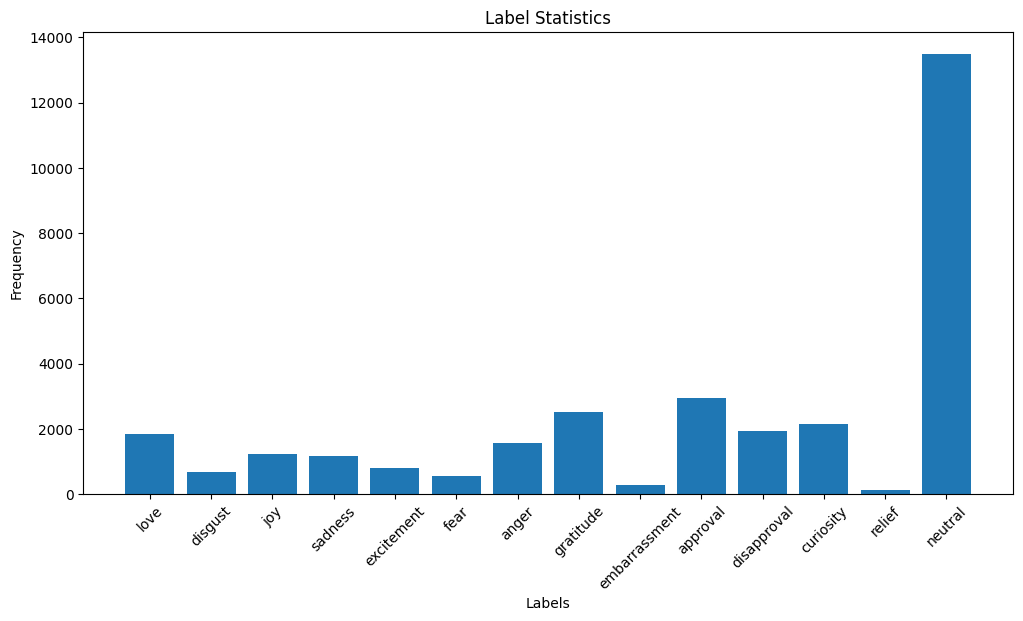

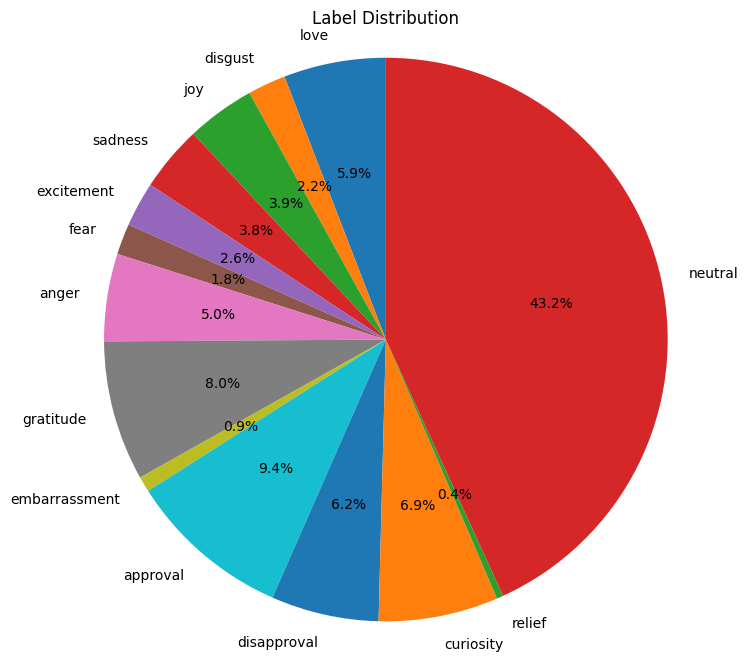

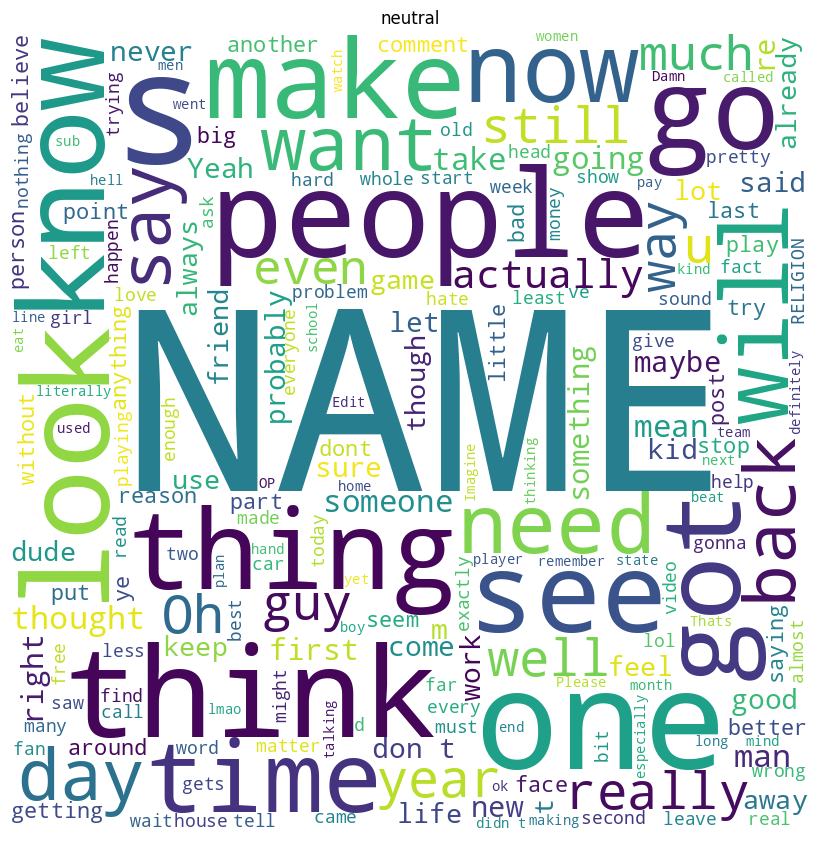

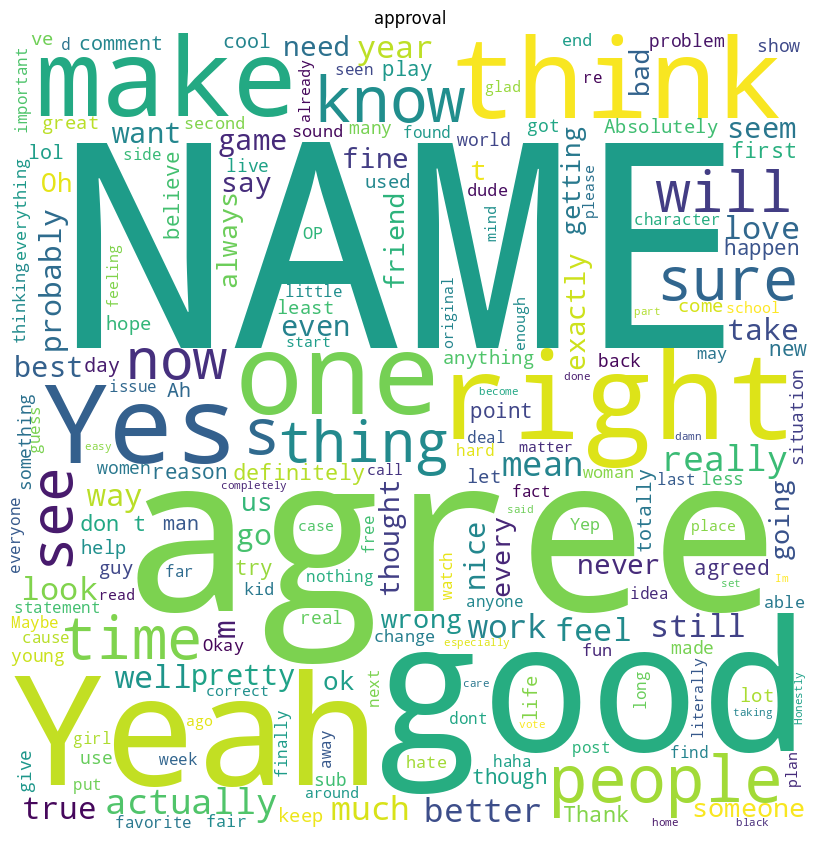

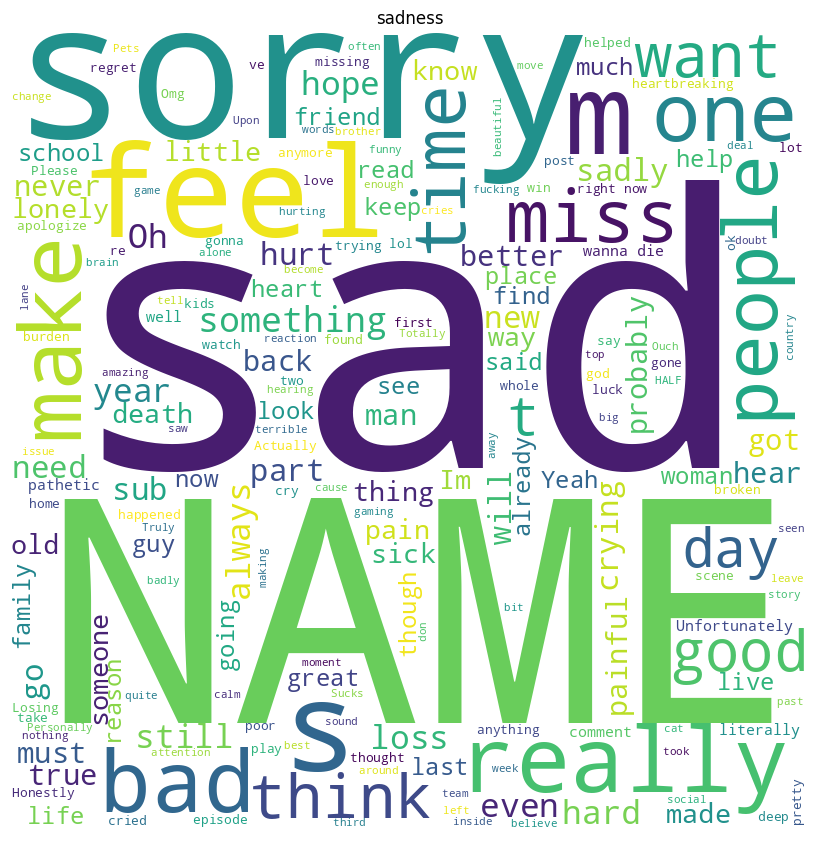

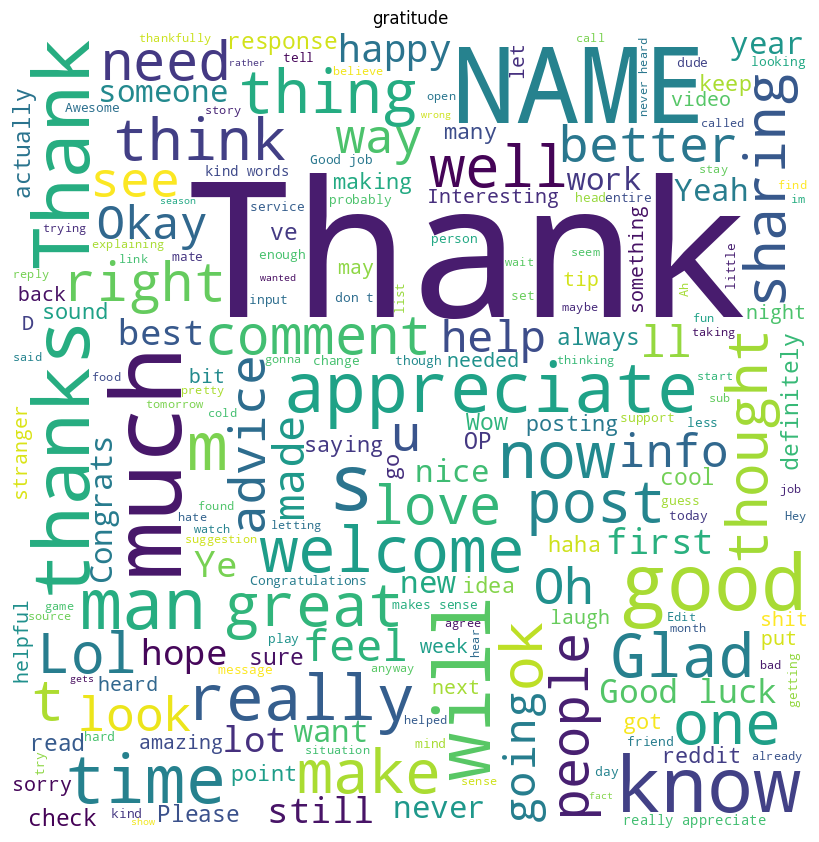

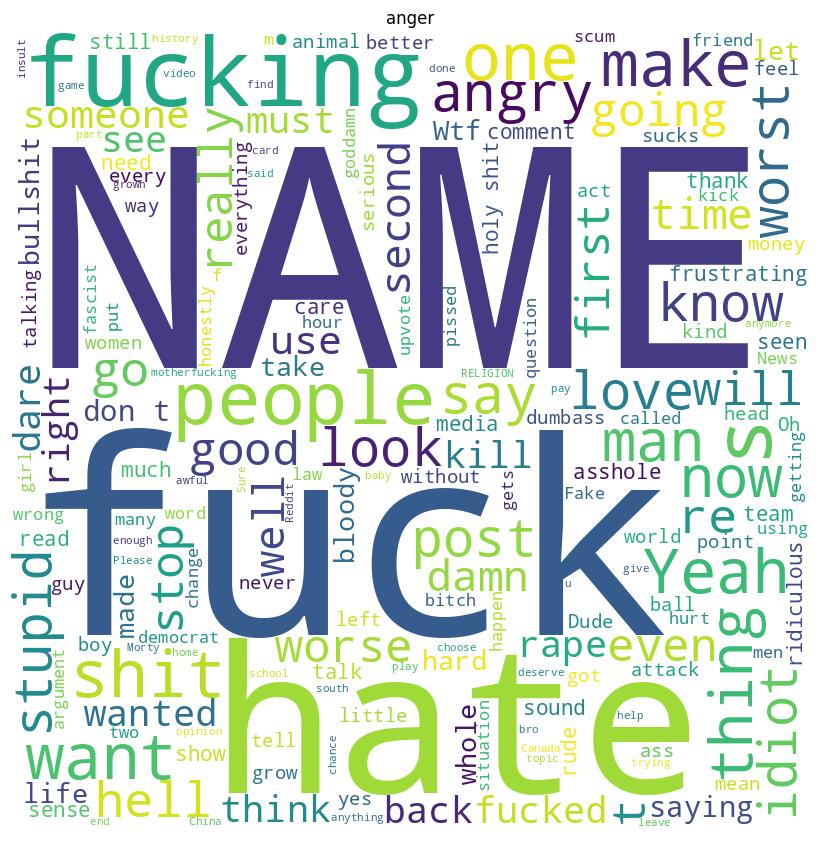

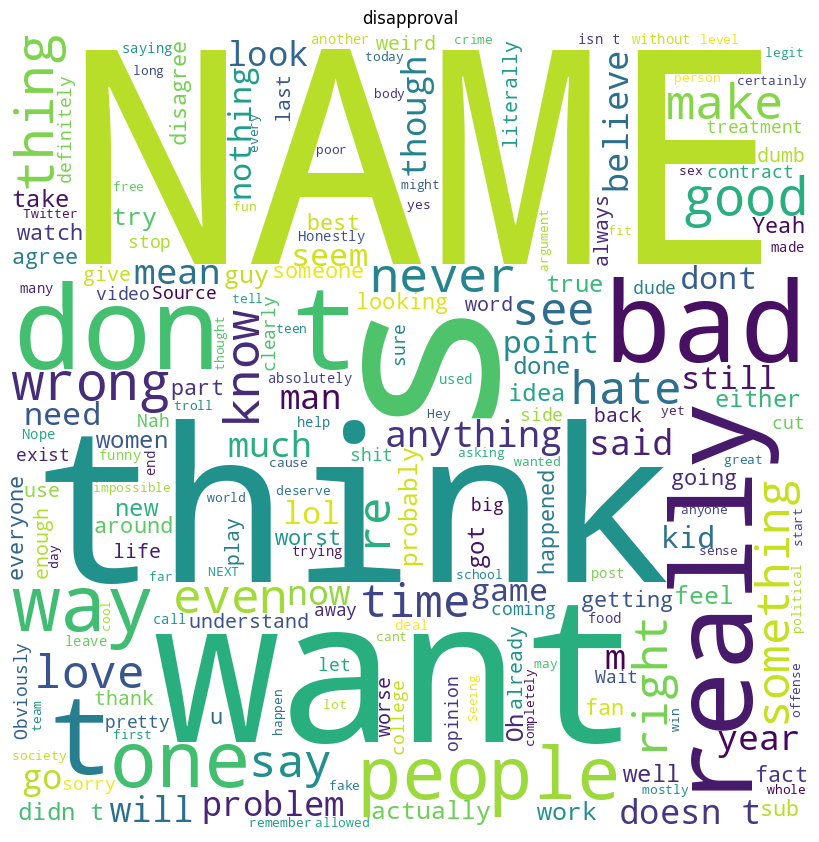

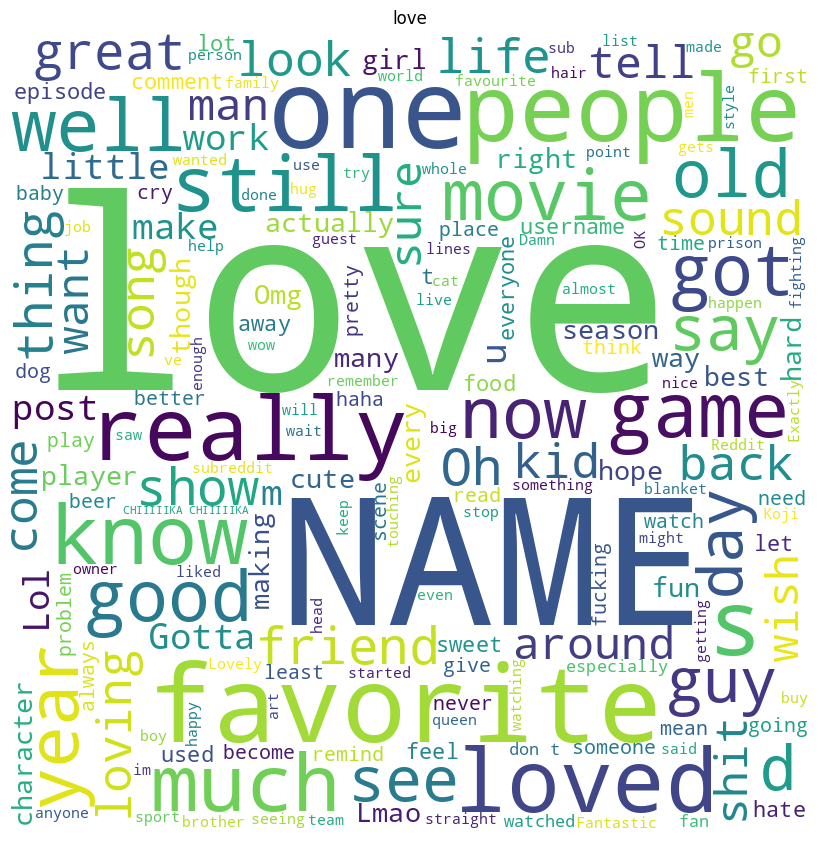

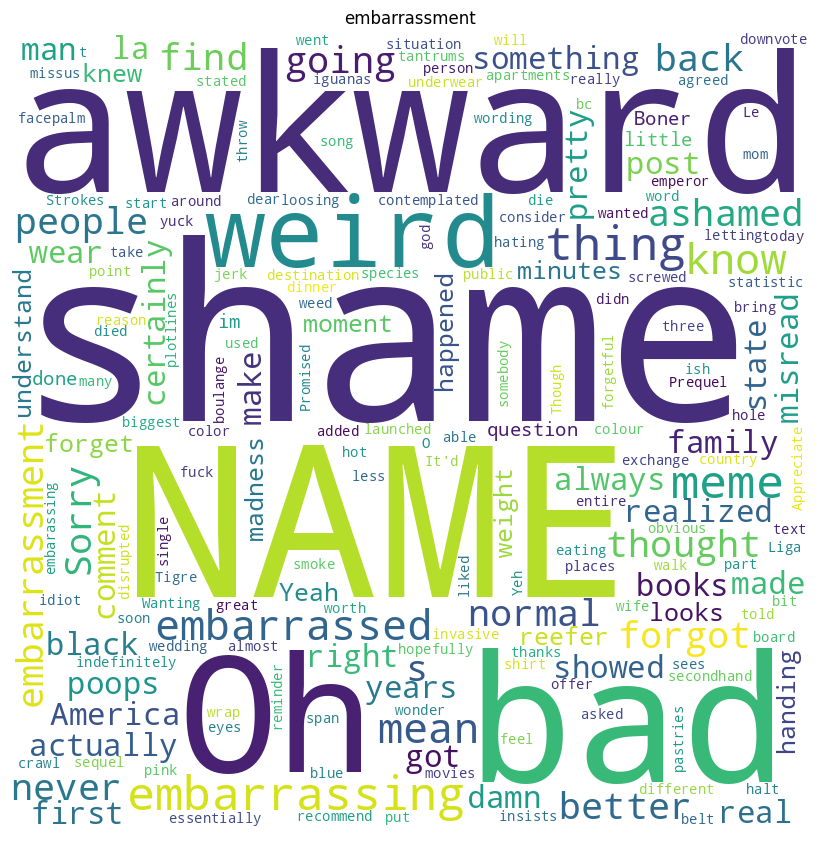

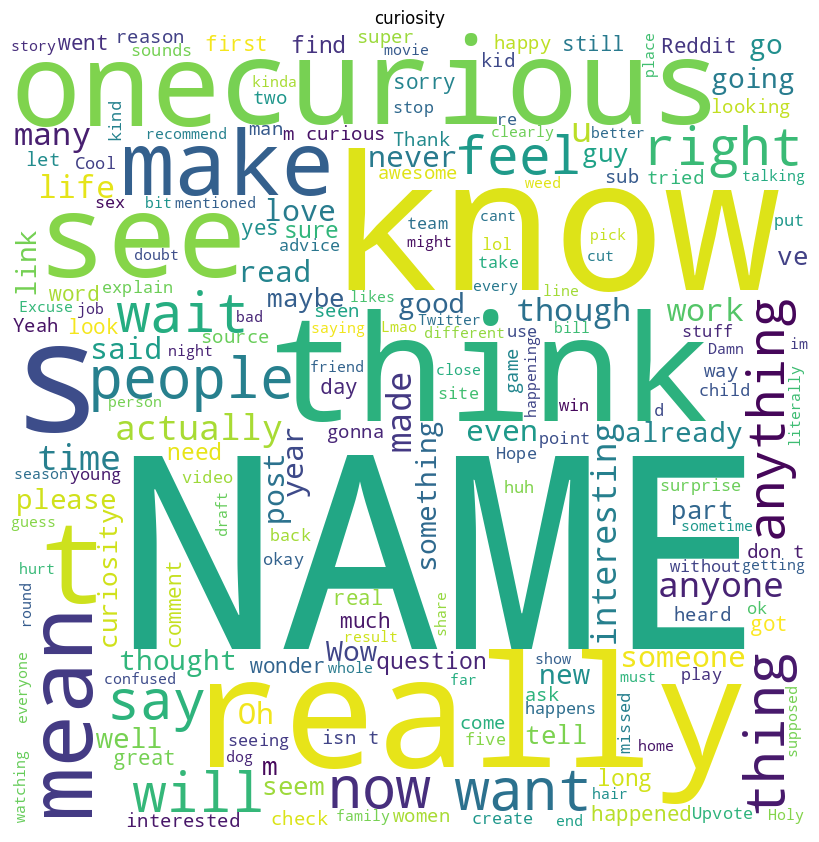

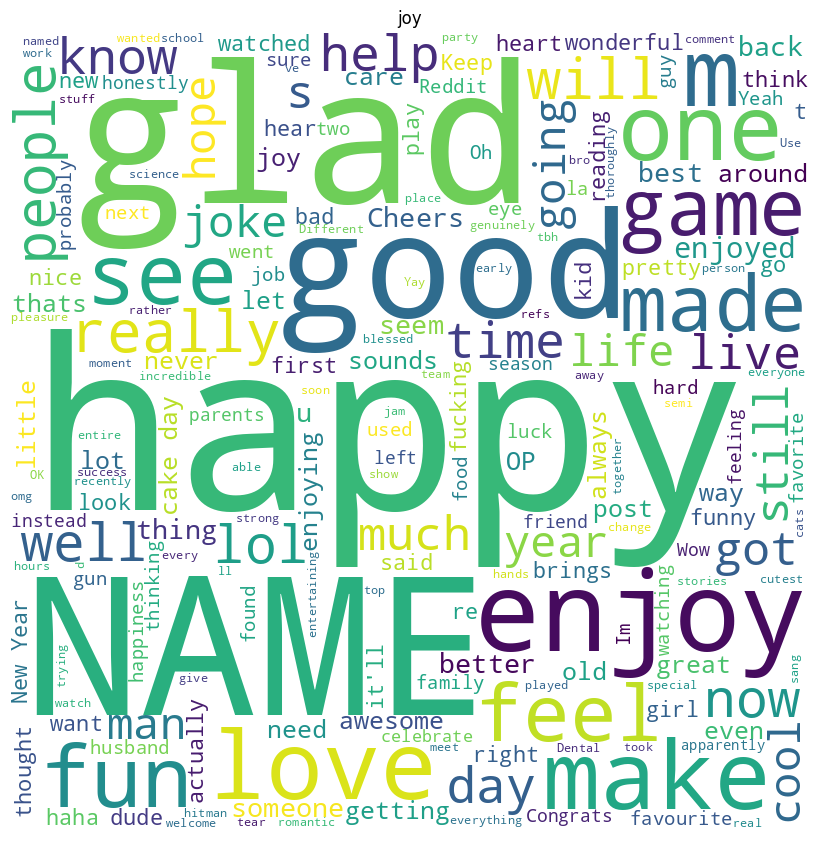

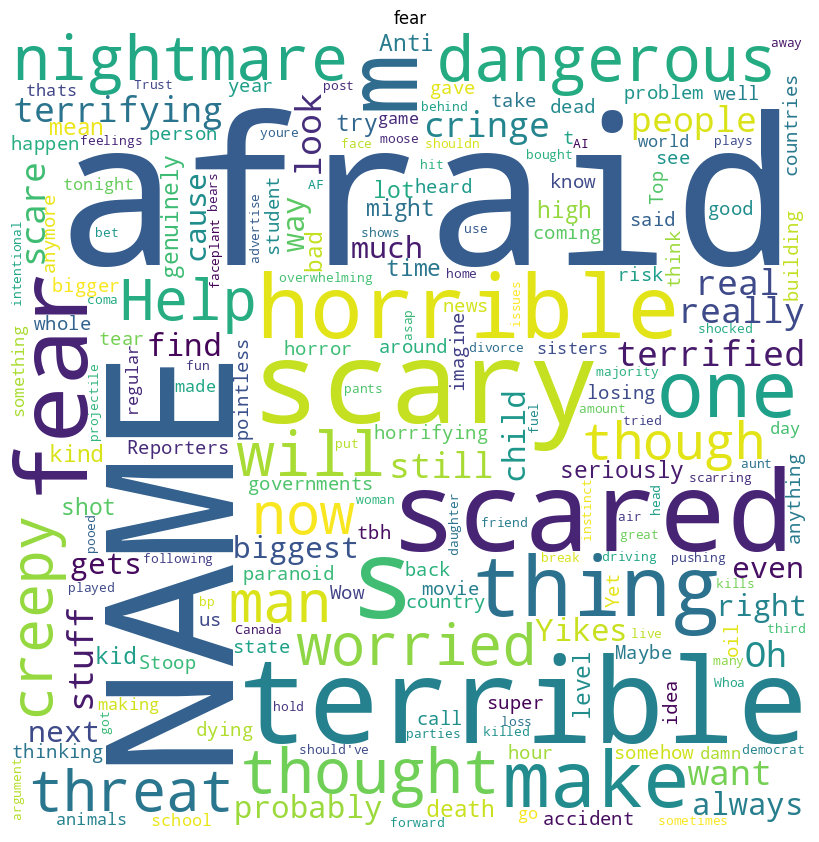

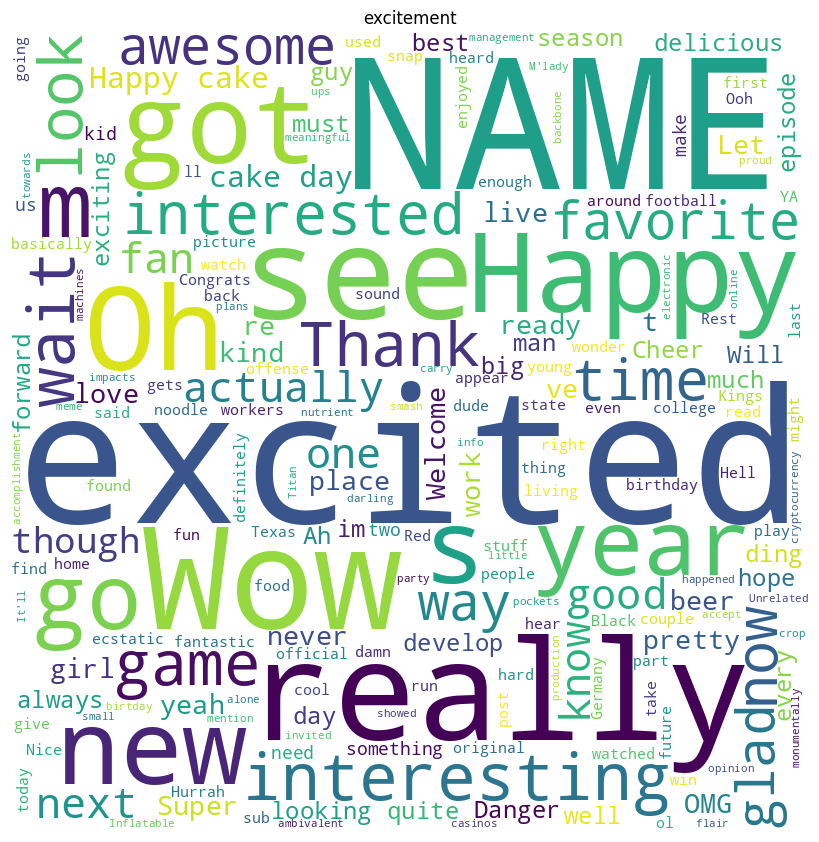

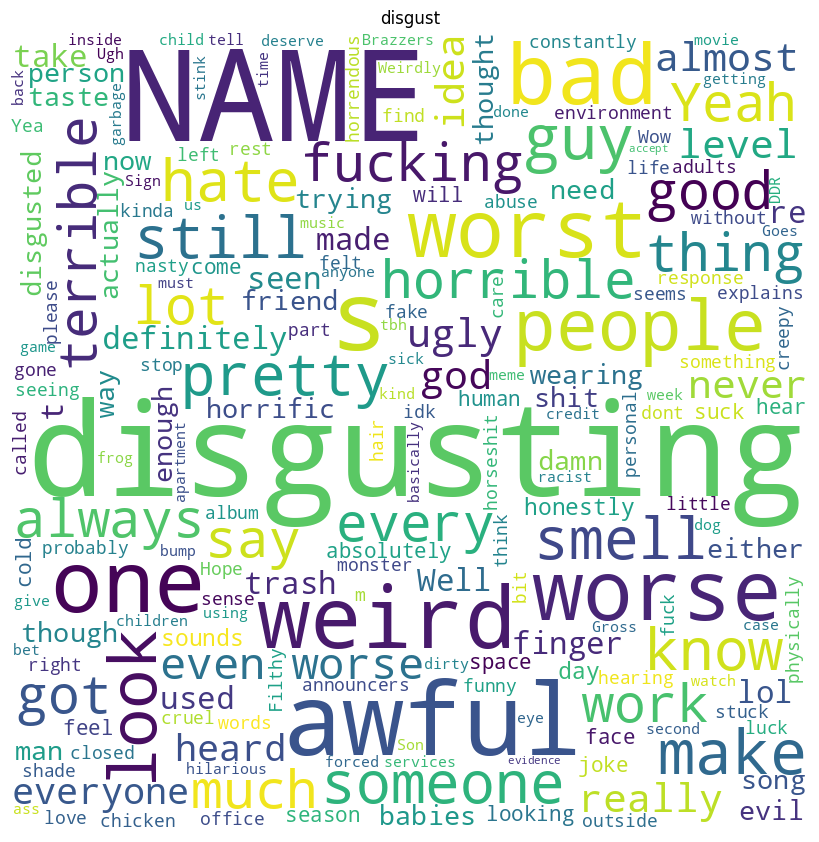

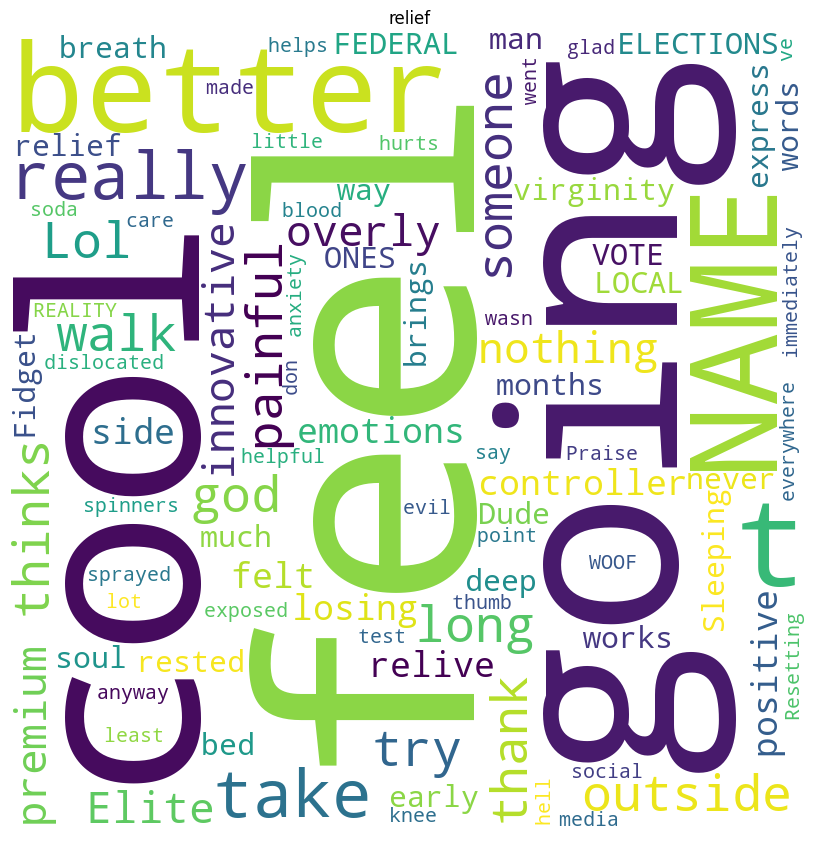

In [32]:
import matplotlib.pyplot as plt

# Bar chart for label statistics
plt.figure(figsize=(12, 6))
plt.bar(label_statistics.keys(), label_statistics.values())
plt.xlabel("Labels")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Label Statistics")
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(label_statistics.values(), labels=label_statistics.keys(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Label Distribution")
plt.show()

from wordcloud import WordCloud

# Visualise label_frequency_statistics in a worldcloud
for label, text in label_frequency_statistics.items():
  wordcloud = WordCloud(width=800, height=800, background_color="white", min_font_size=10).generate(text)
  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.title(label_map[label])
  plt.show()


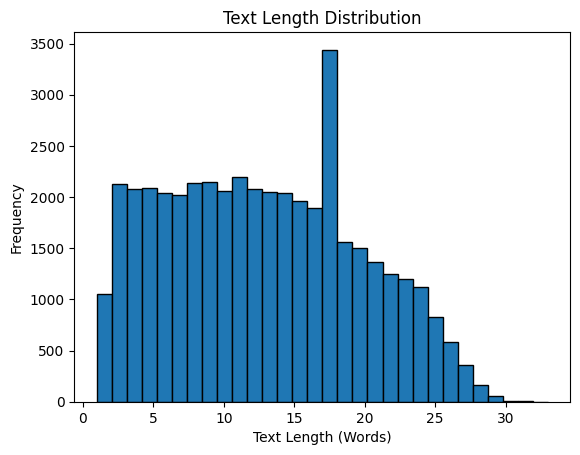

average text length: 12.840175074867542


In [33]:
# Text lengths histogram
plt.hist(text_lengths, bins=30, edgecolor="black")
plt.xlabel("Text Length (Words)")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

avg_text_length = sum(text_lengths) / len(text_lengths)
print(f"average text length: {avg_text_length}")

---
## 2. Train

In [34]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
from transformers import AutoModelForSequenceClassification

# Replace 'bert-base-uncased' with the pre-trained model of your choice
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [35]:
from transformers import Trainer, TrainingArguments

# Set training arguments
training_args = TrainingArguments(
  output_dir="output",
  num_train_epochs=3,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  evaluation_strategy="epoch",
  logging_dir="logs",
  learning_rate=2e-5,
  weight_decay=0.01,
)

# Define the Trainer
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=2928, training_loss=0.9831837617634424, metrics={'train_runtime': 749.3249, 'train_samples_per_second': 125.041, 'train_steps_per_second': 3.908, 'total_flos': 1444816898334720.0, 'train_loss': 0.9831837617634424, 'epoch': 3.0})

In [36]:
from datasets import load_metric
import numpy as np
from sklearn.metrics import confusion_matrix

accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  conf_matrix = confusion_matrix(labels, predictions)

  return {
    "accuracy": accuracy_metric.compute(predictions=predictions, references=labels),
    "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted"),
    "confusion_matrix": conf_matrix
  }

# Define the Trainer
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  compute_metrics=compute_metrics
)

# Evaluate the model on the validation dataset
val_results = trainer.evaluate()

# Evaluate the model on the test dataset
trainer.eval_dataset = test_dataset
test_results = trainer.evaluate()

# Pretty print the results
def print_results(results, dataset_name):
    print(f"{dataset_name} results:")
    print(f"  Loss: {results['eval_loss']:.4f}")
    print(f"  Accuracy: {results['eval_accuracy']['accuracy']:.4f}")
    print(f"  F1 score: {results['eval_f1']['f1']:.4f}")
    print(f"  Runtime: {results['eval_runtime']:.4f}")
    print(f"  Samples per second: {results['eval_samples_per_second']:.4f}")
    print(f"  Steps per second: {results['eval_steps_per_second']:.4f}")
    print()

# Use the function to print the results
print_results(val_results, "Validation")
print_results(test_results, "Test")

Trainer is attempting to log a value of "{'accuracy': 0.6672625127681308}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6611887687182173}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[ 115    4    3   10   11    0    1    1    2    0    4    0    4   40]
 [   6  150   10   12    0    1    4    2    9   16   16    0    8  161]
 [   6    1  162    2    0    0    9    2    1    0    2    0    2   51]
 [  19    7    4  122   11    0    1    1    3    0    4    0    1  114]
 [   9    4    0    2   41    0    0    7    0    0    3    0    1   18]
 [   1    1    0    2    3   16    0    0    2    0    0    0    2    5]
 [   3    3    4    1    0    0   32    0    7    8    8    0    0   21

Validation results:
  Loss: 1.0044
  Accuracy: 0.6673
  F1 score: 0.6612
  Runtime: 7.5343
  Samples per second: 519.7600
  Steps per second: 16.3250

Test results:
  Loss: 0.9669
  Accuracy: 0.6772
  F1 score: 0.6756
  Runtime: 8.1229
  Samples per second: 480.4940
  Steps per second: 15.0190



In [37]:
test_results["eval_confusion_matrix"]

array([[ 120,    2,    7,   14,   10,    0,    0,    1,    3,    0,    3,
           0,    1,   37],
       [   2,  155,   13,   15,    1,    0,    4,    1,    9,   13,   10,
           0,    2,  126],
       [   4,    1,  190,    4,    0,    1,    4,    2,    3,    1,    2,
           0,    4,   56],
       [  10,    4,    7,  115,    9,    1,    1,    1,    1,    1,    6,
           0,    7,   89],
       [  14,    2,    4,    9,   53,    0,    0,    8,    0,    0,    0,
           0,    1,   16],
       [   2,    0,    1,    4,    2,   12,    0,    2,    0,    0,    0,
           0,    2,    8],
       [   0,    8,    6,    2,    0,    0,   44,    2,    6,   11,    0,
           0,    0,   20],
       [   1,    1,    1,    3,    4,    0,    1,   57,    0,    0,    0,
           0,    1,    8],
       [   0,    7,    7,    2,    0,    0,    8,    0,  298,    9,    0,
           0,    1,    3],
       [   0,    5,    2,    1,    0,    0,    9,    1,    2,   91,    8,
           0,    

### Visualise confusion matrix

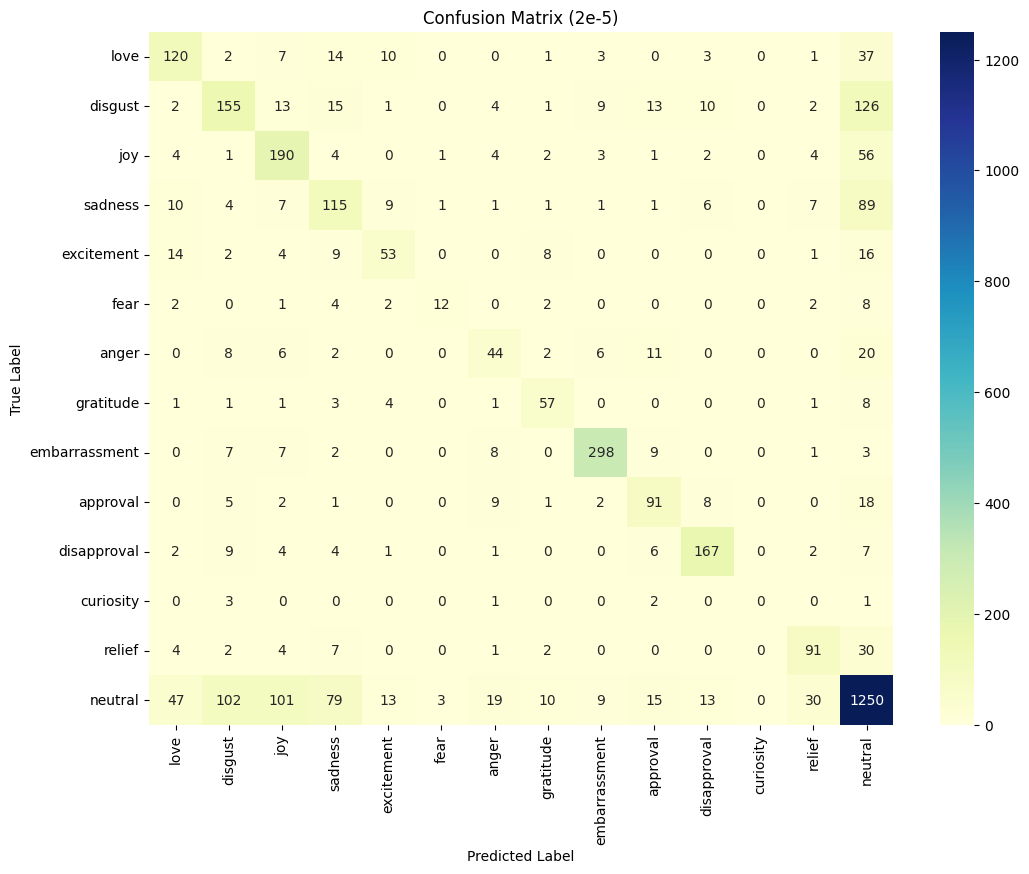

In [40]:
import pandas as pd
import seaborn as sns

conf_matrix = test_results["eval_confusion_matrix"]

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_map.values(), columns=label_map.values())

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix (2e-5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [39]:
output_dir = "."
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json',
 './tokenizer.json')